## Setup

In [32]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get and print current working directory
cwd = os.path.dirname(os.getcwd())
print("Current working directory:", cwd)

# Define output path
output_dir = os.path.join(cwd, "data", "aoi")
dir_figure = os.path.join(cwd, "figures")


Current working directory: d:\natcap\invest-mental-health


In [33]:

# Load shapefiles
dir_shp = 'D:/data/shp/US_census_Cartographic_Boundary_Shapefiles' 

dir_place     = os.path.join(dir_shp, 'UAC/cb_2020_us_place_500k/cb_2020_us_place_500k.shp')
dir_place_cdc = 'D:/natcap/PLACES/raw/500Cities_City_11082016/CityBoundaries.shp'

dir_state     = os.path.join(dir_shp, "cb_2020_us_state_500k/cb_2020_us_state_500k.shp")



## Places within Metro

original place_data: 
     (32188, 22)

filterred place_data (n >= 50,000, density >= 1500 per km2):
    (491, 22)


Cities, which have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2) 
-- based on `Degree of Urbanization` by World Bank [https://blogs.worldbank.org/en/sustainablecities/how-do-we-define-cities-towns-and-rural-areas]

```
        
        pop   >= 50k              pop_d >= 1k/km2           city-code                 in metro
32,188 --------------------> 796 --------------------> 491 --------------------> 467 --------------------> 454


                                  pop_d >= 1.5k/km2
32,188 --------------------> 796 --------------------> 288 --------------------> 276 --------------------> 271

```

In [34]:
import geopandas as gpd

# # Load shapefiles

# Filter Place LSAD
place_lsad_keep = ["00", "25", "CG", "MG", "MT", "UG"]

met_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_metro_combined_metdiv_no_overlap.shp"))
# pla_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_place_with_population_filtered_1500_288.shp") ) # filtered by population density >= 1,500 people/km²
pla_layer = gpd.read_file(os.path.join(cwd, "data", "aoi", "cb_2020_us_place_with_population_filtered_1000_491.shp") ) # filtered by population density >= 1,000 people/km²

place_layer = pla_layer[pla_layer['LSAD'].isin(place_lsad_keep)]

# print(met_layer)
# print(pla_layer)
print('pla_layer: \n\t', pla_layer.shape)
print('place_layer (filter cities): \n\t', place_layer.shape)
print(met_layer.shape)

print(met_layer.columns)
print(place_layer.columns)

pla_layer: 
	 (491, 22)
place_layer (filter cities): 
	 (467, 22)
(410, 23)
Index(['CSAFP', 'CBSAFP', 'METDIVFP', 'AFFGEOID', 'GEOID_METR', 'NAME_METRO',
       'NAMELSAD', 'LSAD_x', 'ALAND_METR', 'AWATER_MET', 'MDIV', 'LSAD_y',
       'SBASE2020', 'POP2020', 'POP2021', 'POP2022', 'POP2023', 'POP2024',
       'GEOID_MDIV', 'POP_KM2', 'count', 'level', 'geometry'],
      dtype='object')
Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID', 'GEOID_PLAC', 'NAME_PLACE',
       'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER', 'SUMLEV',
       'STATE', 'PLACE', 'POP2020', 'POP2021', 'POP2022', 'POP2023', 'POP2024',
       'POP_KM2', 'geometry'],
      dtype='object')


### save places that within_or_overlap with Metro

In [35]:
# Ensure both GeoDataFrames use the same CRS
if met_layer.crs != place_layer.crs:
    print("Reprojecting place_layer to match met_layer CRS...")
    place_layer = place_layer.to_crs(met_layer.crs)

    
# Filter places: retain only those that intersect with metropolitan areas
# Spatial join: keep full Place polygons that intersect with any Metro
places_in_met = gpd.sjoin(
    place_layer, met_layer, 
    how='inner',             # Only keep matching Places
    predicate='intersects'   # Places that touch or overlap Metro
).drop(columns="index_right")

print(places_in_met.columns)

print(f"Places retained: {len(places_in_met)}")
print('places_in_met (filter by Metro): \n\t', places_in_met.shape)



# 📌 You might noticed the filter data geberate more `Places`, this is because
#   If a single Place overlaps multiple Metropolitan areas, then gpd.sjoin(..., how='inner') 
#   will duplicate that Place once for each Metro it intersects.
# For example:
# A Place overlaps 2 Metros → appears twice in the join result.
# A Place overlaps 3 Metros → appears 3 times.
# And so on.
# --> to fix it and get distinct places, we need to drop duplicates after the spatial join

places_in_met_unique = places_in_met.drop_duplicates(['GEOID_PLAC', 'NAME_PLACE'], keep='first')

print('places_in_met_unique (filter by Metro): \n\t', places_in_met_unique.shape)
n_places = len(places_in_met_unique)


# save filtered places
f = os.path.join(cwd, "data", "aoi", f"places_in_or_touching_metros_{n_places}.shp")
places_in_met_unique.to_file(f)



Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID_left', 'GEOID_PLAC',
       'NAME_PLACE', 'NAMELSAD_left', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'SUMLEV', 'STATE', 'PLACE', 'POP2020_left', 'POP2021_left',
       'POP2022_left', 'POP2023_left', 'POP2024_left', 'POP_KM2_left',
       'geometry', 'CSAFP', 'CBSAFP', 'METDIVFP', 'AFFGEOID_right',
       'GEOID_METR', 'NAME_METRO', 'NAMELSAD_right', 'LSAD_x', 'ALAND_METR',
       'AWATER_MET', 'MDIV', 'LSAD_y', 'SBASE2020', 'POP2020_right',
       'POP2021_right', 'POP2022_right', 'POP2023_right', 'POP2024_right',
       'GEOID_MDIV', 'POP_KM2_right', 'count', 'level'],
      dtype='object')
Places retained: 542
places_in_met (filter by Metro): 
	 (542, 44)
places_in_met_unique (filter by Metro): 
	 (454, 44)


C:\Users\pc\AppData\Local\Temp\ipykernel_8152\574240314.py:39: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  places_in_met_unique.to_file(f)
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'AFFGEOID_left' to 'AFFGEOID_l'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'NAMELSAD_left' to 'NAMELSAD_l'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POP2020_left' to 'POP2020_le'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POP2021_left' to 'POP2021_le'
  ogr_write(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages

### plot

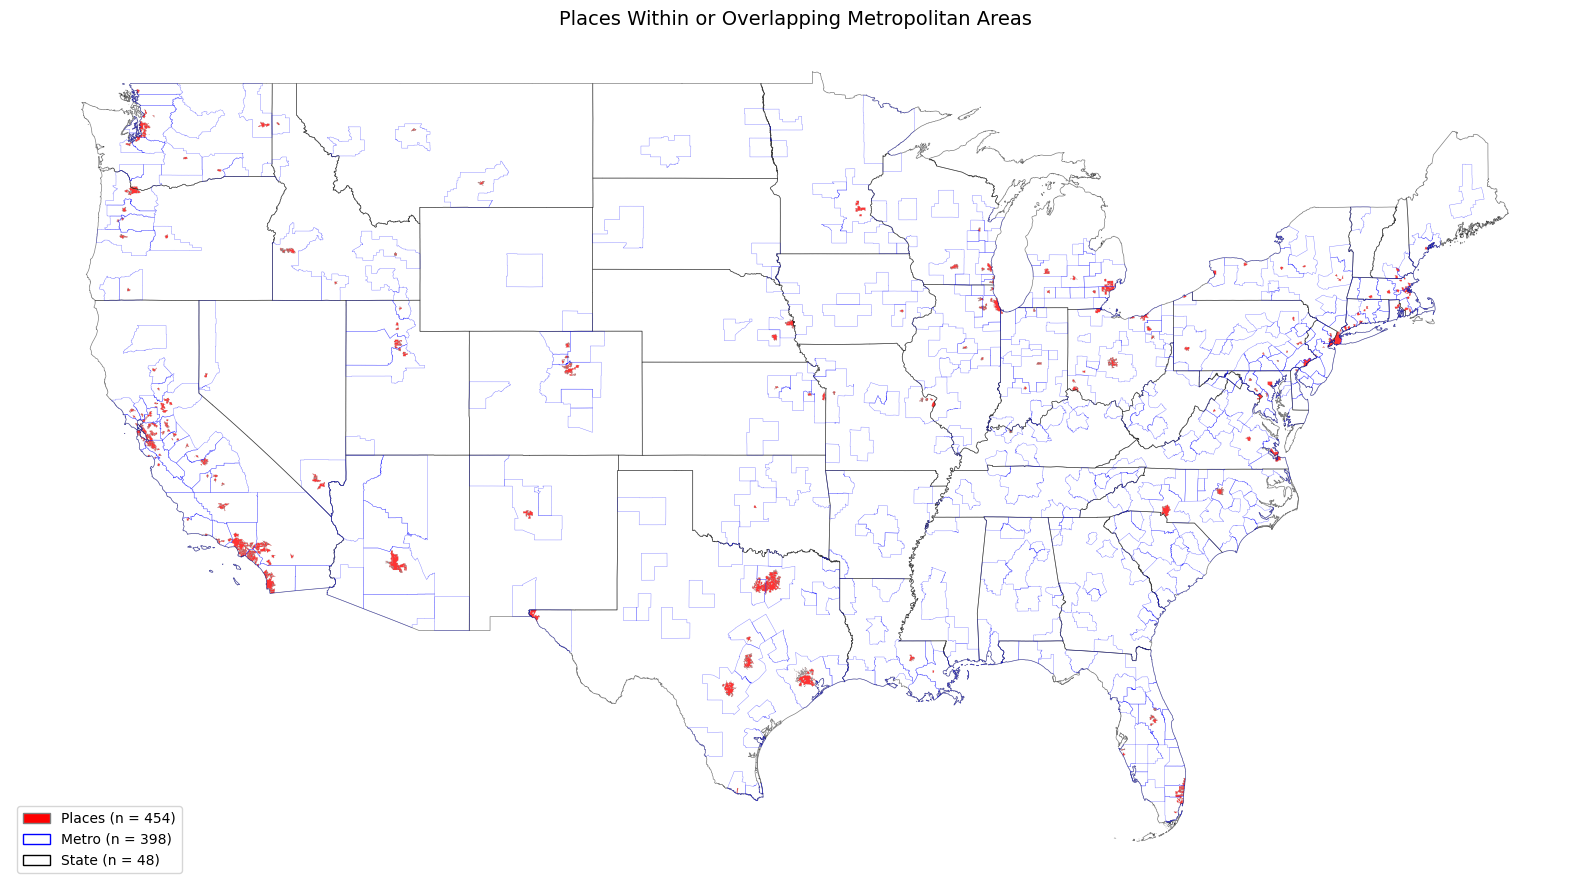

✅ Plot saved to: d:\natcap\invest-mental-health\figures\places_within_metros_454.png


In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import os

# Set working directory or output path
f = f"places_within_metros_{n_places}.png"
output_path = os.path.join(dir_figure, f)

# Load your data (if not already loaded)
# place_layer = gpd.read_file("path/to/place.shp")
# met_layer = gpd.read_file("path/to/metro.shp")
# places_in_met_unique = ...

# Add derived STATEFP column from GEOID_METR
# met_layer['STATEFP'] = met_layer['GEOID_METR'].str[:2]
# Extract state abbreviation (e.g., "CA") from NAME_METRO
met_layer['STATE_ABBR'] = met_layer['NAME_METRO'].str.extract(r',\s*([A-Z]{2})$')


# print(met_layer.head())
# STATEFP codes to exclude: AK, HI, PR, GU, VI, AS, MP, etc.
excluded_statefp = ['02', '15', '60', '66', '69', '72', '78'] 
excluded_statefp_w_dc = excluded_statefp + ['11']  # '11' is DC
excluded_state_abbr = ['AK', 'HI', 'PR', 'GU', 'VI', 'AS', 'MP']

places_in_met_unique_mainland = places_in_met_unique[~places_in_met_unique['STATEFP'].isin(excluded_statefp)]

# met_layer_mainland = met_layer[~met_layer['STATEFP'].isin(excluded_statefp)]
met_layer_mainland = met_layer[~met_layer['STATE_ABBR'].isin(excluded_state_abbr)]


## 3. state layer -------
# Load state boundaries (make sure you have this file)
state_layer = gpd.read_file(dir_state)

# Exclude non-mainland states
state_layer_mainland = state_layer[~state_layer['STATEFP'].isin(excluded_statefp_w_dc)] 
# print(state_layer_mainland)
# Print sorted state names
# print(state_layer_mainland['NAME'].sort_values().to_list())

## Plot -------------------------------------------------------------------------------

# Ensure consistent CRS for plotting
if places_in_met_unique_mainland.crs != met_layer_mainland.crs:
    met_layer_mainland = met_layer_mainland.to_crs(places_in_met_unique_mainland.crs)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))


# Plot state boundaries (black)
state_layer_mainland.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)

# Plot metro boundaries
met_layer_mainland.boundary.plot(ax=ax, color='blue', linewidth=.3, alpha=0.5)

# Plot places
places_in_met_unique_mainland.plot(ax=ax, color='red', edgecolor='gray', linewidth=0.1, alpha=0.8)


# Custom legend
legend_elements = [
    Patch(facecolor='red', edgecolor='gray', label=f'Places (n = {len(places_in_met_unique_mainland)})'),
    Patch(facecolor='none', edgecolor='blue', label=f'Metro (n = {len(met_layer_mainland)})'),
    Patch(facecolor='none', edgecolor='black', label=f'State (n = {len(state_layer_mainland)})')
]
ax.legend(handles=legend_elements, loc='lower left')

# Title and formatting
ax.set_title("Places Within or Overlapping Metropolitan Areas", fontsize=14)
ax.axis("off")

# Save as PNG
plt.tight_layout()
plt.savefig(output_path, dpi=1200)
plt.show()

print(f"✅ Plot saved to: {output_path}")


###  Overlap area calculation


In [37]:

# ======= Overlap area calculation =======

# Compute exact intersection geometries
intersection = gpd.overlay(
    places_in_met_unique, met_layer, 
    how='intersection', 
    keep_geom_type=False
)

# # Compute area of intersections
# intersection['overlap_area'] = intersection.geometry.area

# Reproject to a projected CRS (e.g., EPSG:5070 = NAD83 / Conus Albers, perfect for the U.S.)
projected_crs = "EPSG:5070"  # Or use EPSG:3857 for Web Mercator
intersection_proj = intersection.to_crs(projected_crs)

# Now compute area in km2
intersection_proj['overlap_km2'] = (intersection_proj.geometry.area / 1e6).round(2)

print(intersection_proj.columns)


Index(['STATEFP', 'PLACEFP', 'PLACENS', 'AFFGEOID_left', 'GEOID_PLAC',
       'NAME_PLACE', 'NAMELSAD_left', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'SUMLEV', 'STATE', 'PLACE', 'POP2020_left', 'POP2021_left',
       'POP2022_left', 'POP2023_left', 'POP2024_left', 'POP_KM2_left',
       'CSAFP_1', 'CBSAFP_1', 'METDIVFP_1', 'AFFGEOID_right', 'GEOID_METR_1',
       'NAME_METRO_1', 'NAMELSAD_right', 'LSAD_x_1', 'ALAND_METR_1',
       'AWATER_MET_1', 'MDIV_1', 'LSAD_y_1', 'SBASE2020_1', 'POP2020_right',
       'POP2021_right', 'POP2022_right', 'POP2023_right', 'POP2024_right',
       'GEOID_MDIV_1', 'POP_KM2_right', 'count_1', 'level_1', 'CSAFP_2',
       'CBSAFP_2', 'METDIVFP_2', 'AFFGEOID', 'GEOID_METR_2', 'NAME_METRO_2',
       'NAMELSAD', 'LSAD_x_2', 'ALAND_METR_2', 'AWATER_MET_2', 'MDIV_2',
       'LSAD_y_2', 'SBASE2020_2', 'POP2020', 'POP2021', 'POP2022', 'POP2023',
       'POP2024', 'GEOID_MDIV_2', 'POP_KM2', 'count_2', 'level_2',
       'STATE_ABBR', 'geometry', 'o

In [38]:

# Group by GEOID and NAME_PLACE, summing overlap areas
metro_place = (
    intersection_proj.groupby(['GEOID_METR_1', 'GEOID_METR_2', 'NAME_METRO_1', 'GEOID_PLAC', 'NAME_PLACE'])['overlap_km2']
    .sum()
    .reset_index()
)

print("Sample of overlap areas:")
print(metro_place.head())

print(places_in_met_unique.shape)
print(metro_place.shape)

print(intersection_proj.geometry.geom_type.unique())


Sample of overlap areas:
  GEOID_METR_1 GEOID_METR_2        NAME_METRO_1 GEOID_PLAC NAME_PLACE  \
0        10420        10420           Akron, OH    3901000      Akron   
1        10540        10540  Albany-Lebanon, OR    4101000     Albany   
2        10540        10540  Albany-Lebanon, OR    4115800  Corvallis   
3        10540        18700  Albany-Lebanon, OR    4101000     Albany   
4        10540        18700  Albany-Lebanon, OR    4115800  Corvallis   

   overlap_km2  
0       161.35  
1        36.07  
2         0.00  
3        10.25  
4        37.45  
(454, 44)
(542, 6)
['Polygon' 'LineString' 'GeometryCollection' 'MultiPolygon'
 'MultiLineString']
